### This notebook takes the reader through all the test data used throughout the manuscript and creates clean and usable files for each panel

For each saved file, the fields correspond to :
<pre>
`sequence` : the sequence
`Measured Expression` : the measured expression (or expression change in the case of files containing 'delta' in the name)  in the corresponding media 
`Predicted Expression` : the predicted expression (or expression change in the case of files containing 'delta' in the name)  in the corresponding media using the TPU model.
</pre>
The GPU model version of these figures can be reproduced using the sequence here and the GPU model code shared.

### Imports

In [1]:


import argparse,pwd,os,numpy as np,h5py
from os import makedirs
from os.path import splitext,exists,dirname,join,basename , realpath
import multiprocessing as mp, ctypes
from sklearn.metrics import *
from scipy.stats import *
import time , csv ,pickle ,joblib , matplotlib  , multiprocessing,itertools
from joblib import Parallel, delayed 
import seaborn as sns
import os, gc , datetime , sklearn , scipy , pydot , random  
from tqdm import tqdm 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras import Input
from tensorflow.keras.layers import  Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten , Conv1D, Concatenate , Permute
from tensorflow.keras.layers import Bidirectional,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Add , LeakyReLU ,Reshape , Activation , MaxPooling1D , Lambda , Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import conv1d
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import h5py , tensorflow
import tensorflow as tf, sys, numpy as np, h5py, pandas as pd
from tensorflow import nn
from os import makedirs
#from tensorflow.keras.utils import multi_gpu_model
import glob , math




##Matplotlib rc params
# Font family : https://matplotlib.org/tutorials/introductory/customizing.html , http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/ , https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib , https://stackoverflow.com/questions/26106552/matplotlib-style-library-not-updating-when-mplstyle-files-added-deleted , https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html , http://www.jesshamrick.com/2016/04/13/reproducible-plots/ , 
#
from matplotlib import rcParams
rcParams.update(matplotlib.rcParamsDefault)
rcParams['pdf.fonttype'] = 42
sns.set(context = 'paper' , style='ticks' , 
        rc = {
            'figure.autolayout' : True,
            'axes.titlesize' : 8 ,
            'axes.titleweight' :'bold',
            
            'figure.titleweight' : 'bold' ,
            'figure.titlesize' : 8 ,
            
            'axes.labelsize' : 8 ,
            'axes.labelpad' : 2 ,
            'axes.labelweight' : 'bold' , 
            'axes.spines.top' : False,
            'axes.spines.right' : False,
            
            'xtick.labelsize' : 7 ,
            'ytick.labelsize' : 7 ,
            
            'legend.fontsize' : 7 ,
            'figure.figsize' : (3.5, 3.5/1.6 ) ,          
            
            'xtick.direction' : 'out' ,
            'ytick.direction' : 'out' ,
            
            'xtick.major.size' : 2 ,
            'ytick.major.size' : 2 ,
            
            'xtick.major.pad' : 2,
            'ytick.major.pad' : 2,
            
            #'lines.linewidth' : 1            
            
             } )


##


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

### The function for making each of the plots below and for computing the Pearson's r and p-value

In [2]:


def plot(predicted_expressions, expressions ,is_delta = 0, model_name = 'TPU model' , regplot =0) :
    fig=plt.figure(figsize=(3, 3) , dpi= 300, facecolor='w', edgecolor='k')
    fig.tight_layout(pad = 1)



    x = list(predicted_expressions)
    y = list(expressions)

    r = scipy.stats.pearsonr(x ,y )
    if regplot : 
        sns.regplot(x=x ,y=y ,
                    scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                    line_kws= {'linewidth':2} ,
                    color= '#0868ac', robust = 1 )

    else : 
        sns.scatterplot(x= x , y=y , s= 1 , linewidth = 0 , rasterized = 1 , color  = '#0868ac')

    ax = plt.gca()
    #ax.get_legend().remove()


    if is_delta : 
        ax.set_xlabel(model_name + " predicted expression change")
        ax.set_ylabel("Measured expression change")
        
    else :
        ax.set_xlabel(model_name + " predicted expression")
        ax.set_ylabel("Measured expression")
    if (r[1] ==0.0) :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
    else :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    #plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-8,xmax=8)
    #ax.set_ylim(ymin=-8,ymax=8)
    plt.show()

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
- These files are available on the CodeOcean/VM shared.

In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own. 
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own


In [25]:
first_run = 0 ### Set this to 0 as a user since this has already been run once and the simplified files have been saved
regplot = 1 ### Set this to 0 if you just want a scatterplot quickly and not a line of best fit

In [6]:
if first_run : 
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')


### Random Test Data (Complex Media)

In [7]:
if first_run : 
    df = pd.read_csv('../../../results_summary/Random_test_tpu_model.csv' , index_col = 0)
    df.to_csv('Random_complex.csv')
else :
    df = pd.read_csv('Random_complex.csv' , index_col = 0)

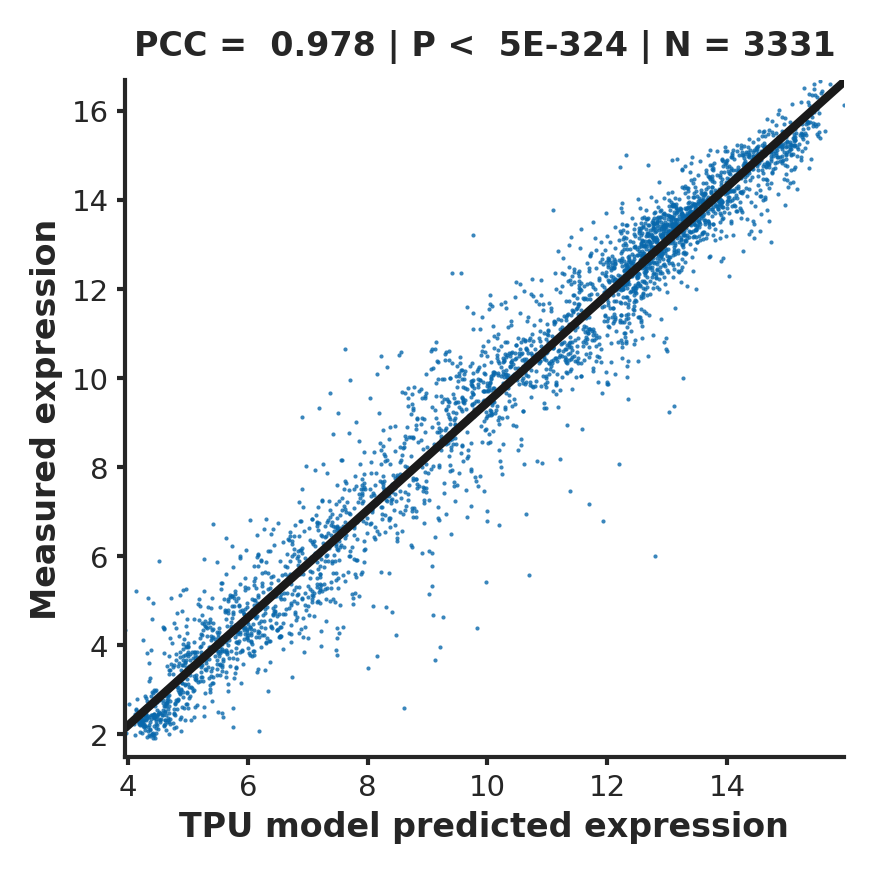

In [8]:

    
plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 0, model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit as in manuscript

### Native Test Data (Complex Media)

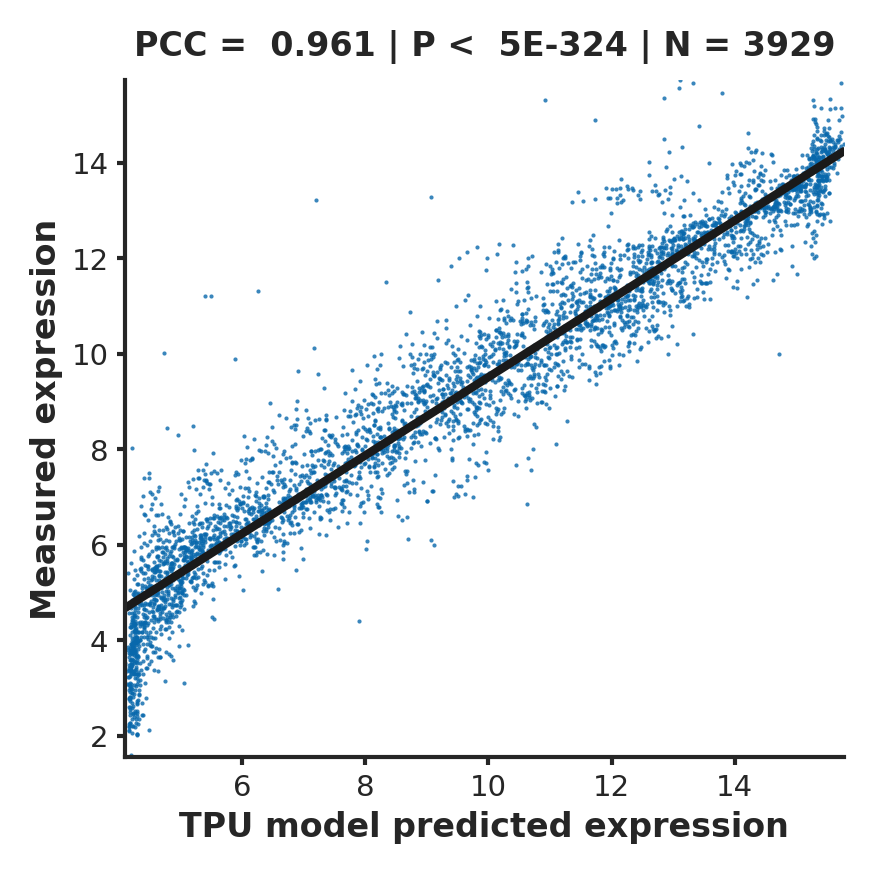

In [9]:
if first_run : 
    df = pd.read_csv('../../../results_summary/Native_test_tpu_model.csv' , index_col = 0)
    df.to_csv('Native_complex.csv')
else : 
    df = pd.read_csv('Native_complex.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , model_name = 'TPU model' , regplot =regplot ) # change regplot = 1 if you want line of best fit as in manuscript

### Random Test Data (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users

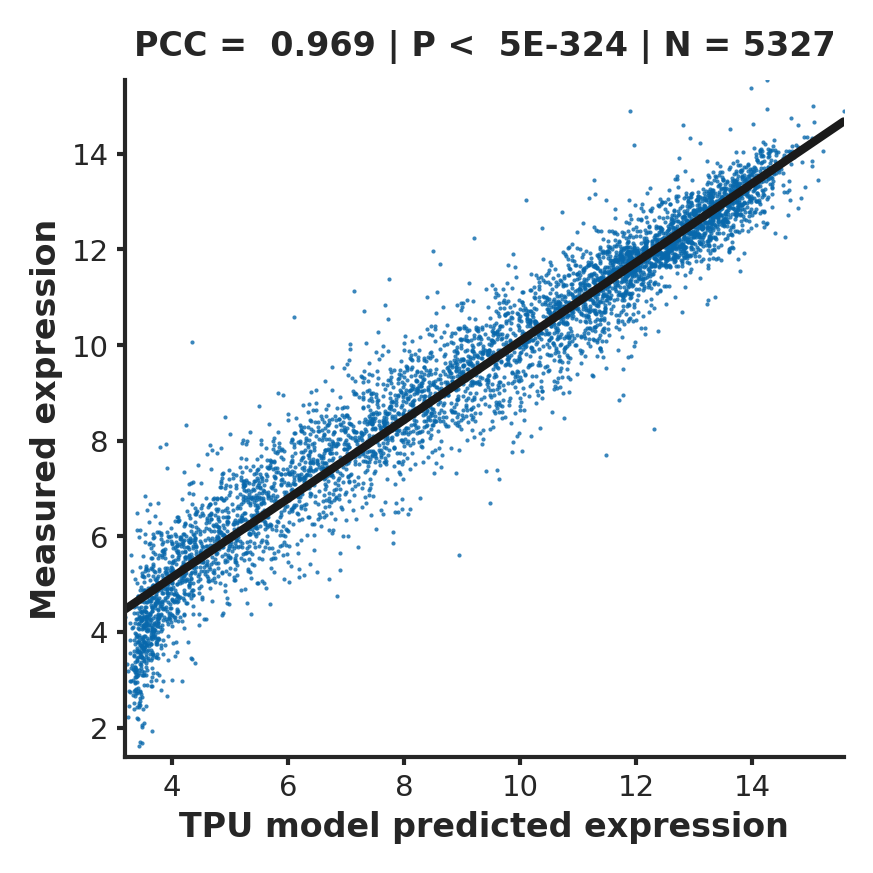

In [10]:
if first_run : 
    extracted_df = full_df[(full_df.HQ==1) & (full_df.expt=='NBT_S288CdU_SCUra') ]
    
    ### Remove the couple dozen spike-ins for noise measurement to make it impossible for users to use it wrong.
    df = pd.read_csv('../../../data/test_data/Random_testdata_defined_media.csv' , sep=',' , index_col =0)
    
    extracted_df = extracted_df[extracted_df['seq110'].isin(
                    np.intersect1d(extracted_df['seq110'].values,df['seq110'].values ))]
    
    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df.meanEL.values)
    df['Predicted Expression'] = list(extracted_df.edvPred.values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Random_defined.csv')
    
else : 
    df = pd.read_csv('Random_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit as in manuscript

### Native Test Data (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users

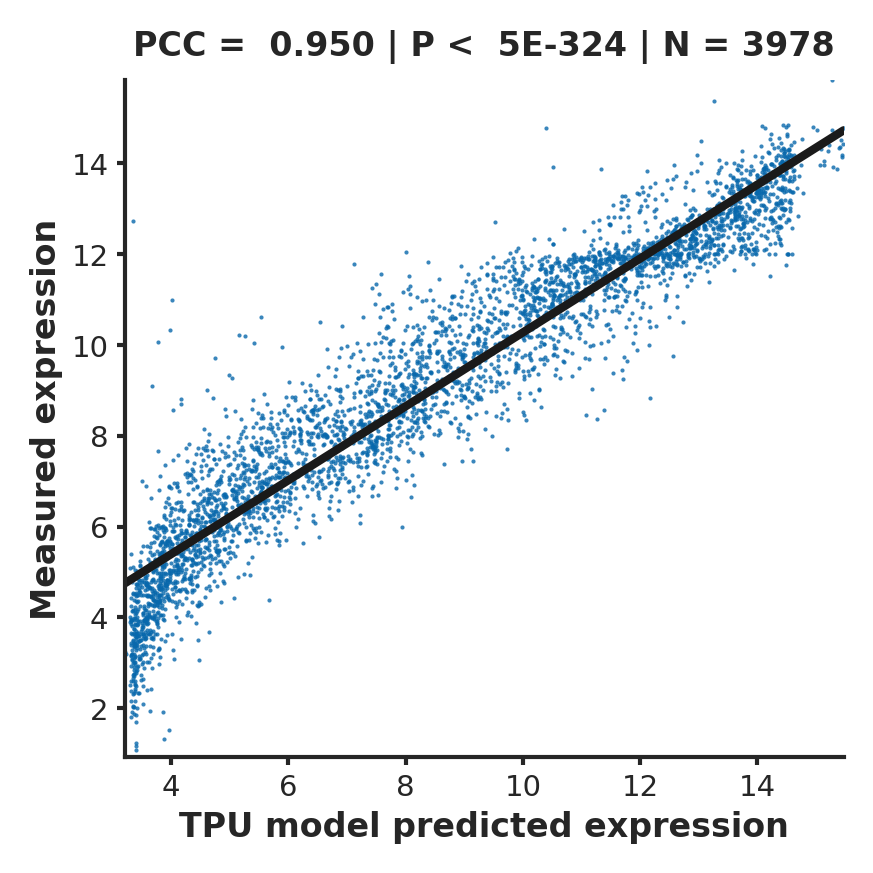

In [11]:
if first_run : 

    extracted_df = full_df[(full_df.native==1) & (full_df.expt=='NBT_S288CdU_SCUra') ]

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df.meanEL.values)
    df['Predicted Expression'] = list(extracted_df.edvPred.values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Native_defined.csv')
    
else : 
    df = pd.read_csv('Native_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , model_name = 'TPU model' , regplot =regplot) 
# change regplot = 1 if you want line of best fit


### Drift Test Data (change in expression) (Complex Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users

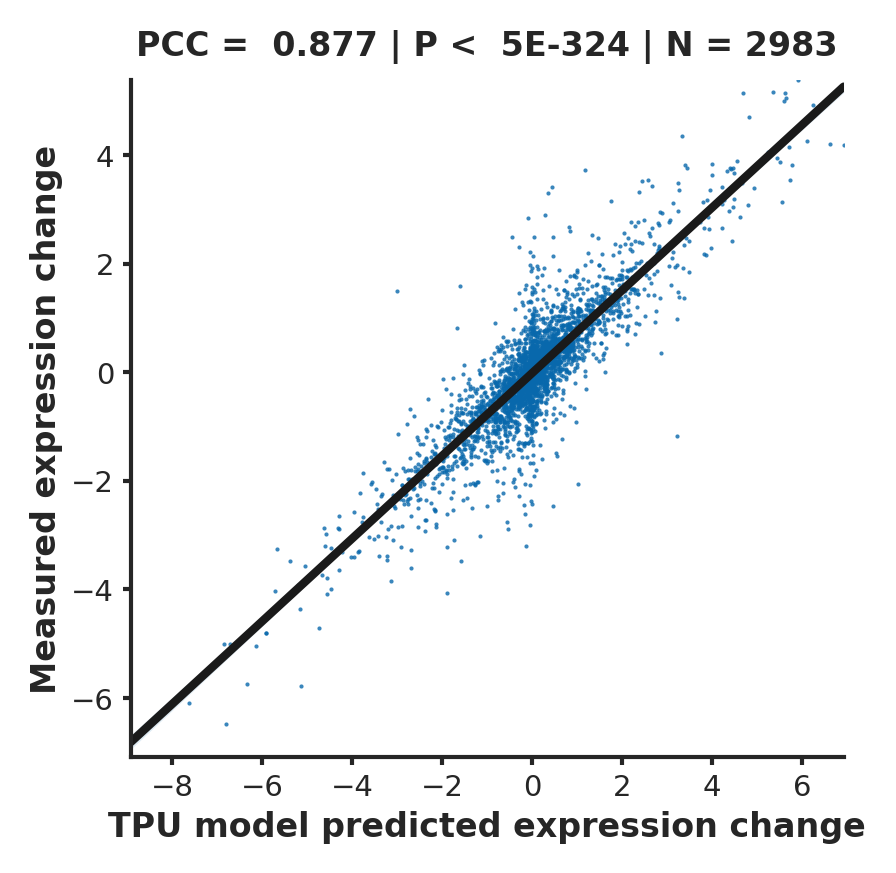

In [12]:
if first_run : 
    extracted_df =  snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_YPD')]

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL.delta'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred.delta'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Drift_delta_complex.csv')
    
else : 
    df = pd.read_csv('Drift_delta_complex.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 1, model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### Drift Test Data (expression) (Complex Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


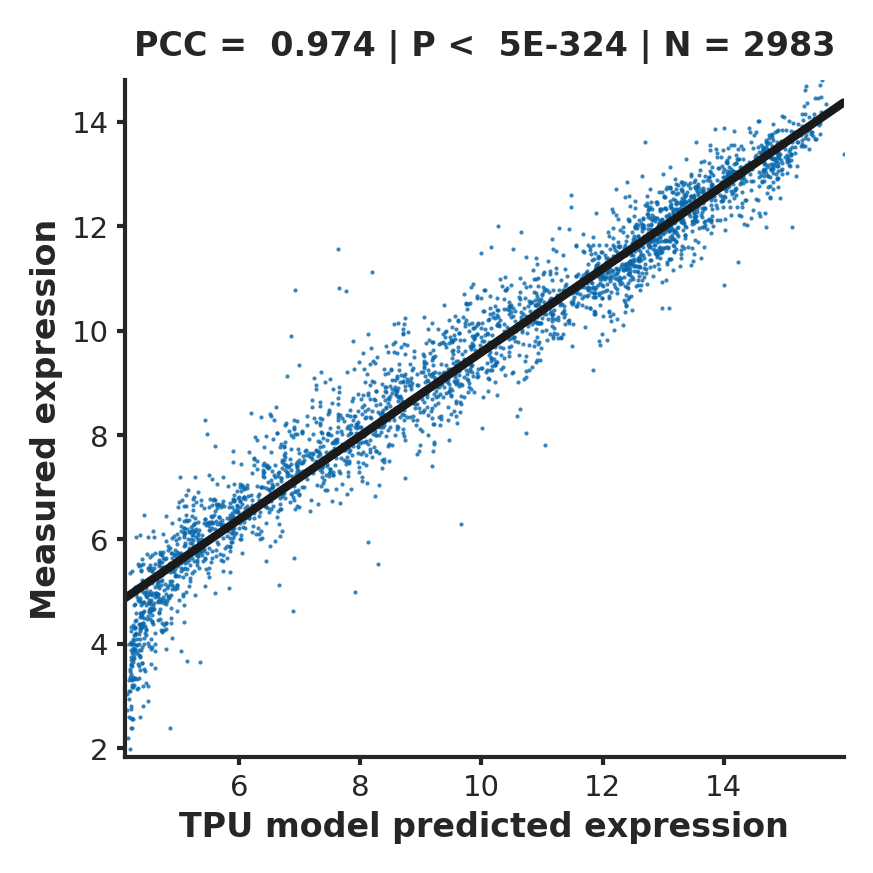

In [13]:
if first_run : 

    extracted_df = snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_YPD')] 

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL.mut'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred.mut'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Drift_complex.csv')
    
else : 
    df = pd.read_csv('Drift_complex.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### Drift Test Data (change in expression) (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users

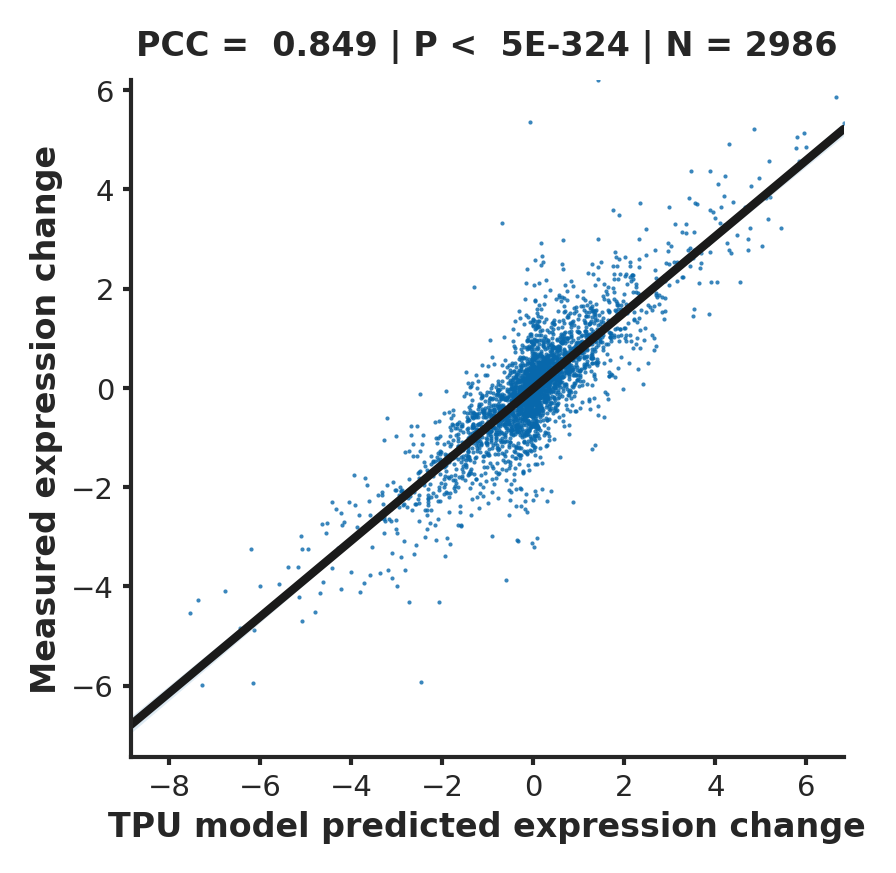

In [14]:
if first_run : 
    extracted_df =  snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_SCUra')]

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL.delta'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred.delta'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Drift_delta_defined.csv')
    
else : 
    df = pd.read_csv('Drift_delta_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  ,is_delta = 1, model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### Drift Test Data (expression) (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


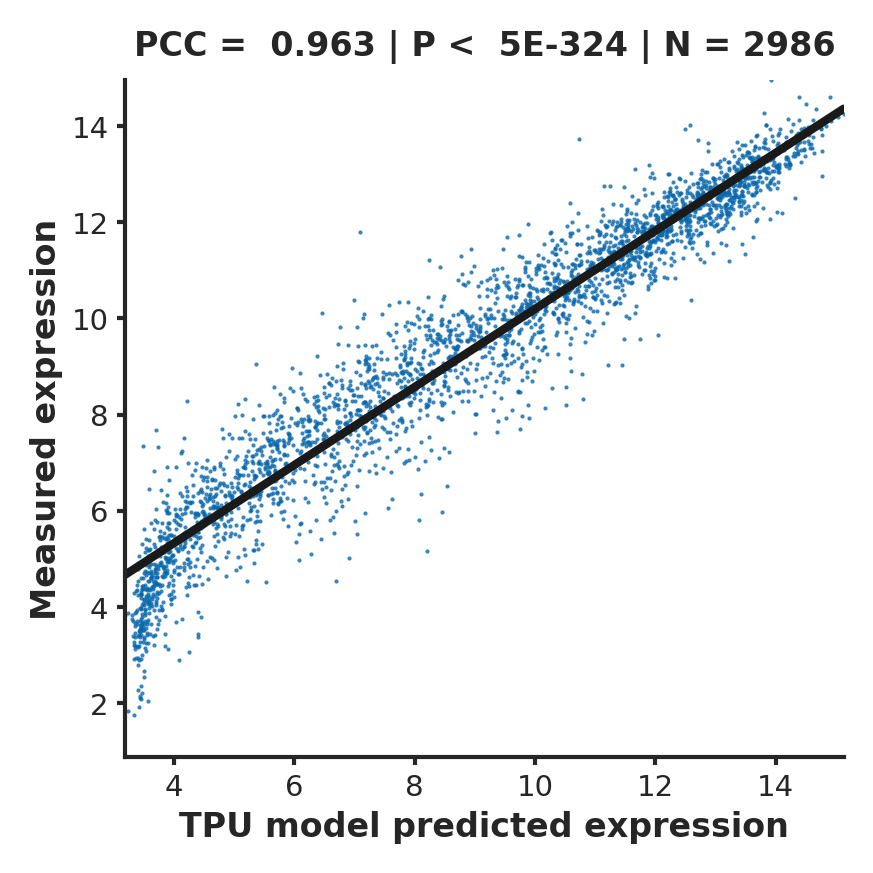

In [15]:
if first_run : 

    extracted_df = snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_SCUra')] 

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL.mut'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred.mut'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('Drift_defined.csv')
    
else : 
    df = pd.read_csv('Drift_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### SSWM Test Data (change in expression) (Complex Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


In [26]:
%%capture
if first_run : 

    #len(baseSeq_list) is 441
    df = full_df[full_df.trajOpt == 'Glu'] #| ( full_df.trajOpt ==  'Glu')
    df = df[df.expt == 'NBT_S288CdU_YPD']
    edvPred_delta = []
    measured_delta = []
    seq_list = []
    
    for trajDir in [ 'inc' , 'dec'] : 
        df_trajDir = df[df.trajDir== trajDir]

        baseSeq_list = [ i for i in np.unique(df.baseSeq)]
        for baseSeq  in tqdm(baseSeq_list) :
            baseSeq_df = df_trajDir[df_trajDir.baseSeq==baseSeq]
            ED_list = baseSeq_df.ED.sort_values().values
            for ED in ED_list :
                if 0 in ED_list:
                    measured_delta = measured_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].meanEL.values - baseSeq_df[baseSeq_df.ED==0].meanEL.values)] 
                    edvPred_delta =edvPred_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].edvPred.values - baseSeq_df[baseSeq_df.ED==0].edvPred.values)] 


    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['Measured Expression'] = measured_delta
    df['Predicted Expression'] = edvPred_delta
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('SSWM_delta_complex.csv')
    
else : 
    df = pd.read_csv('SSWM_delta_complex.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 1 , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### SSWM Test Data (expression) (Complex Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


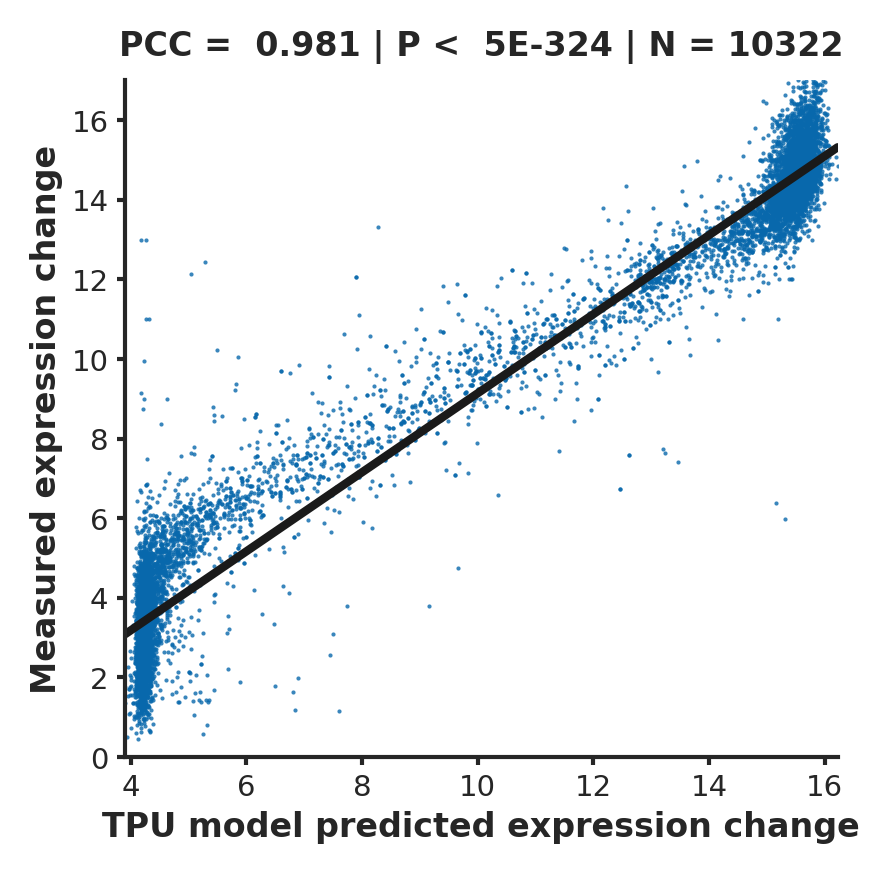

In [17]:
if first_run : 

    extracted_df = full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]


    df.to_csv('SSWM_complex.csv')
    
else : 
    df = pd.read_csv('SSWM_complex.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 1 , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit

    

### SSWM Test Data (change in expression) (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


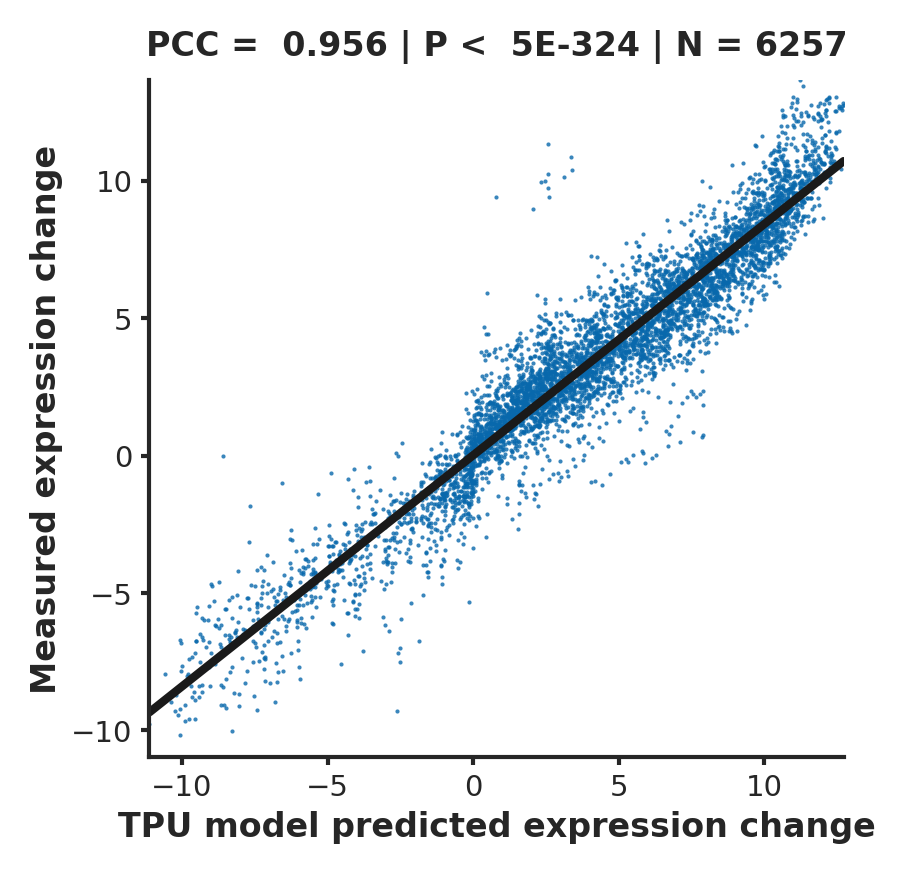

In [27]:
if first_run : 

    #len(baseSeq_list) is 441
    df = full_df[full_df.trajOpt == 'SCUra'] #| ( full_df.trajOpt ==  'Glu')
    df = df[df.expt == 'NBT_S288CdU_SCUra']
    edvPred_delta = []
    measured_delta = []
    seq_list = []
    
    for trajDir in [ 'inc' , 'dec'] : 
        df_trajDir = df[df.trajDir== trajDir]

        baseSeq_list = [ i for i in np.unique(df.baseSeq)]
        for baseSeq  in tqdm(baseSeq_list) :
            baseSeq_df = df_trajDir[df_trajDir.baseSeq==baseSeq]
            ED_list = baseSeq_df.ED.sort_values().values
            for ED in ED_list :
                if 0 in ED_list:
                    measured_delta = measured_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].meanEL.values - baseSeq_df[baseSeq_df.ED==0].meanEL.values)] 
                    edvPred_delta =edvPred_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].edvPred.values - baseSeq_df[baseSeq_df.ED==0].edvPred.values)] 


    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['Measured Expression'] = measured_delta
    df['Predicted Expression'] = edvPred_delta
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]

    df.to_csv('SSWM_delta_defined.csv')
    
else : 
    df = pd.read_csv('SSWM_delta_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 1 , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### SSWM Test Data (expression) (Defined Media)
We extract this data from our single (complicated) internal file with test data results and save it in a simplified file format for users


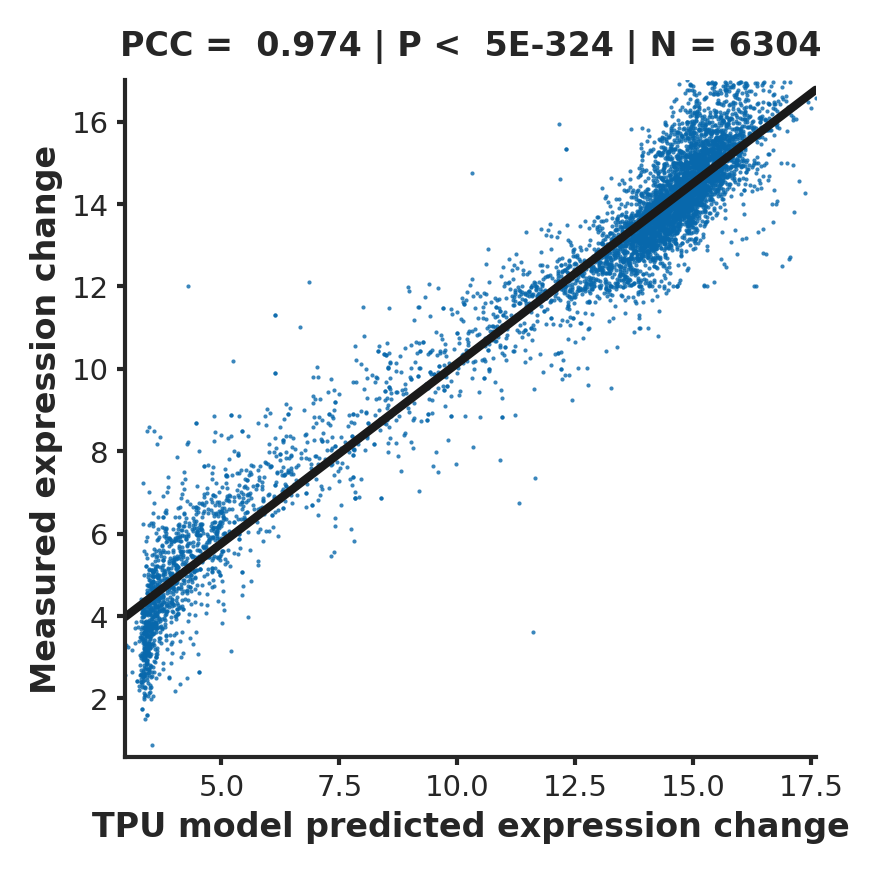

In [19]:
if first_run : 

    extracted_df = full_df[(full_df.trajOpt=='SCUra') & (full_df.expt=='NBT_S288CdU_SCUra')]

    ### Simplify and save
    df = pd.DataFrame(columns={'sequence' , 'Measured Expression' ,'Predicted Expression'})
    df['sequence'] = list(extracted_df.seq110.values)
    df['Measured Expression'] = list(extracted_df['meanEL'].values)
    df['Predicted Expression'] = list(extracted_df['edvPred'].values)
    df = df[['sequence' , 'Measured Expression' ,'Predicted Expression']]


    df.to_csv('SSWM_defined.csv')
    
else : 
    df = pd.read_csv('SSWM_defined.csv' , index_col = 0)

plot( df['Predicted Expression'] , df['Measured Expression']  , is_delta = 1 , model_name = 'TPU model' , regplot =regplot ) 
# change regplot = 1 if you want line of best fit


### Scatterplots for SSWM trajectories at each mutational step | Complex Media

In [20]:
if 0 : 
    extracted_df = full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    extracted_df['Mutational Step'] = extracted_df['ED']  
    extracted_df['Predicted Expression'] = extracted_df['edvPred']  
    extracted_df['Measured Expression'] = extracted_df['meanEL']  
    ### Create title 
    col_order = []
    for i in np.sort(np.unique(extracted_df['ED'])) : 
        step_df = extracted_df[extracted_df['Mutational Step'] == i]
        pcc = scipy.stats.pearsonr(step_df.meanEL,step_df.edvPred)[0]
        colname = str(i) +' | PCC = ' + str(round( pcc, 3))
        extracted_df.loc[extracted_df['Mutational Step'] == i , 'Mutational Step'] =   colname
        col_order = col_order + [colname]

    from matplotlib.backends.backend_pdf import PdfPages

    g = sns.FacetGrid(extracted_df , col = 'Mutational Step' ,  col_wrap=3 , 
                      col_order = col_order )
    g.map(sns.scatterplot,  "Predicted Expression" , "Measured Expression" ,
         s= 2 , linewidth = 0 , rasterized = 1 , color  = '#0868ac')



    figfile = 'SSWM_stepwise_scatterplot_complex_media'

    g.savefig(figfile + ".pdf")
    g.savefig(figfile + ".png")
    plt.show()

### Scatterplots for SSWM trajectories at each mutational step | Defined Media

In [21]:
if 0 : 
    extracted_df = full_df[(full_df.trajOpt=='SCUra') & (full_df.expt=='NBT_S288CdU_SCUra')]
    extracted_df['Mutational Step'] = extracted_df['ED']  
    extracted_df['Predicted Expression'] = extracted_df['edvPred']  
    extracted_df['Measured Expression'] = extracted_df['meanEL']  
    ### Create title 
    col_order = []
    for i in np.sort(np.unique(extracted_df['ED'])) : 
        step_df = extracted_df[extracted_df['Mutational Step'] == i]
        pcc = scipy.stats.pearsonr(step_df.meanEL,step_df.edvPred)[0]
        colname = str(i) +' | PCC = ' + str(round( pcc, 3))
        extracted_df.loc[extracted_df['Mutational Step'] == i , 'Mutational Step'] =   colname
        col_order = col_order + [colname]

    from matplotlib.backends.backend_pdf import PdfPages

    g = sns.FacetGrid(extracted_df , col = 'Mutational Step' ,  col_wrap=3 , 
                      col_order = col_order )
    g.map(sns.scatterplot,  "Predicted Expression" , "Measured Expression" ,
         s= 2 , linewidth = 0 , rasterized = 1 , color  = '#0868ac')

    figfile = 'SSWM_stepwise_scatterplot_defined_media'

    g.savefig(figfile + ".pdf")
    g.savefig(figfile + ".png")
    plt.show()